In [2]:
using Plots, PlotThemes, ColorSchemes
using Statistics, Distributions

theme(:juno)
default(fontfamily="times", size=(1200,400), palette=:seaborn_deep6, linewidth=2)

### Filtro de Kalman Escalar

Diseñamos un filtro de Kalman de expresión autoregresiva con ruido de modelo $\eta[n]$
$$s[n] = A s[n-1]+\eta[n] \qquad\qquad \eta[n]\sim\mathcal N (0,\sigma_\eta^2)$$

Para estimar un parámetro $s$ a partir de mediciones $x[n]$ con ruido de medición $\nu[n]$ 
$$x[n]=s[n]+\nu[n]\phantom{A-1} \qquad\qquad \nu[n]\sim\mathcal N(0, \sigma_\nu^2)$$

Realizamos la implementación del algoritmo para un filtro de Kalman en función de los parámetros de varianza $\sigma_\eta^2$ y $\sigma_\nu^2$ y una estimación inicial $s[0]$ con varianza inicial $M[0]$

$$\begin{array}{llcl}
\text{Predicción:}     & s[n|n-1] = As[n-1|n-1]                 & \longrightarrow & \mathtt{s\_est[i]=A*s[i-1]} \\[1em]
\text{ECM predicción:} & M[n|n-1] = A^2M[n-1|n-1]+\sigma^2_\eta & \longrightarrow & \mathtt{M\_est[i]=A^\land 2*M[i-1]+Var\_n}\\[1em]
\text{Ganancia Kalman:} & K[n] = \dfrac{M[n|n-1]}{\sigma^2_\nu+M[n|n-1]} & \longrightarrow & \mathtt{K[i]=M\_est[i]/(Var\_v+M\_est[i]})\\[1.5em]

\text{Corrección:} & s[n|n] = s[n|n-1]+K[n](x[n]-s[n|n-1]) & \longrightarrow & \mathtt{s[i]=s\_est[i]+K[i]*(x[i]-s\_est[i])}\\[1em]

\text{ECM corrección:} & M[n|n] = (1-K[n])M[n|n-1] & \longrightarrow & \mathtt{M[i]=(1-K[i])*M\_est[i]}\\[1em]
\end{array}
$$

In [3]:
function kalman(x; Var_v, Var_η, A, s0, M0)
    s_est = [A*s0]
    M_est = [A^2*M0+Var_η]
    K = [M_est[1]/(Var_v+M_est[1])]
    s = [s_est[1] + K[1]*(x[1]-s_est[1])]
    M = [(1-K[1])*M_est[1]]

    for i = 2:length(x)
        s_est = [s_est; A*s[i-1]]
        M_est = [M_est; A^2*M[i-1]+Var_η]
        K = [K; M_est[i]/(Var_v+M_est[i])]
        s = [s; s_est[i] + K[i]*(x[i]-s_est[i])]
        M = [M; (1-K[i])*M_est[i]]
    end
    return [s, M, K]
end

kalman (generic function with 1 method)

Usamos el filtro de Kalman para estimar un valor de continua $\theta$ inmerso en ruido, realizando mediciones

$$x[n]=\theta+w[n] \qquad\qquad w[n]\sim\mathcal N(0, \sigma_w^2)$$


In [4]:
x_dist = Normal(10, 1)
x = rand(x_dist, 100);

Para visualizar, graficamos 
- El valor del parámetro a estimar: $\theta$
- La realización de la señal medida: $x[n]$
- La estimación del parámetro: $s[n]$
- El intervalo de confianza de la estimación: $s[n]\pm\sqrt{M[n]}$

In [5]:
function plot_kalman(x, s, θ, M; Var_v, Var_η, A, s0, M0)
    lim = maximum(abs.([extrema(x)..., extrema(s)...]))*1.1
    smin = [s0-sqrt(M0); s.-sqrt.(M)]
    smax = [s0+sqrt(M0); s.+sqrt.(M)]
    vars = [smin, smax]
    p1 = plot(title="A = $A  Var_v = $Var_v  Var_η = $Var_η  s0 = $s0", ylims=(0, lim), legend=:bottomright)
    plot!(p1, [0:length(x)], [s0; s], label="Estimador Kalman")
    plot!(p1, [0:length(x)], vars, linestyle=:dot, color=:teal, label=["Intervalo de Confianza" ""])
    plot!(p1, [0:length(x)], [x[end]; x], label="Realización", linewidth=1, linestyle=:dash)
    plot!(p1, [0, length(x)], [θ, θ], label="Parámetro", linestyle=:dashdot, linewidth=1, color=:grey)
end

plot_kalman (generic function with 1 method)

El filtro de Kalman resulta definido en función de los parámetros:

- `Var_η` : Incerteza en el modelo
- `Var_v` : Incerteza en la medición
- `A` : Factor de transición de estado
- `s0` : Estimación inicial
- `M0` : Error cuadrático medio de estimación inicial

Consideramos un filtro Kalman con igual confianza en las mediciones que en el modelo como referencia `Var_η=1`, `Var_v=1`

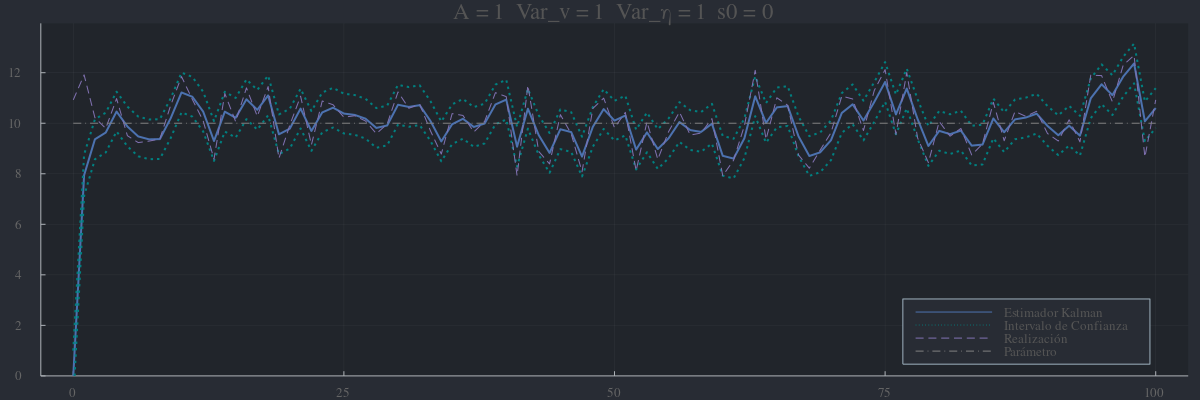

In [6]:
params = (A=1, Var_η=1, Var_v=1, s0=0, M0=1)
    
s, M, K = kalman(x; params...)
plot_kalman(x, s, 10, M; params...)

Evaluamos el efecto de confiar más en el modelo que en las mediciones: `Var_η=0.1` y `Var_v=10`

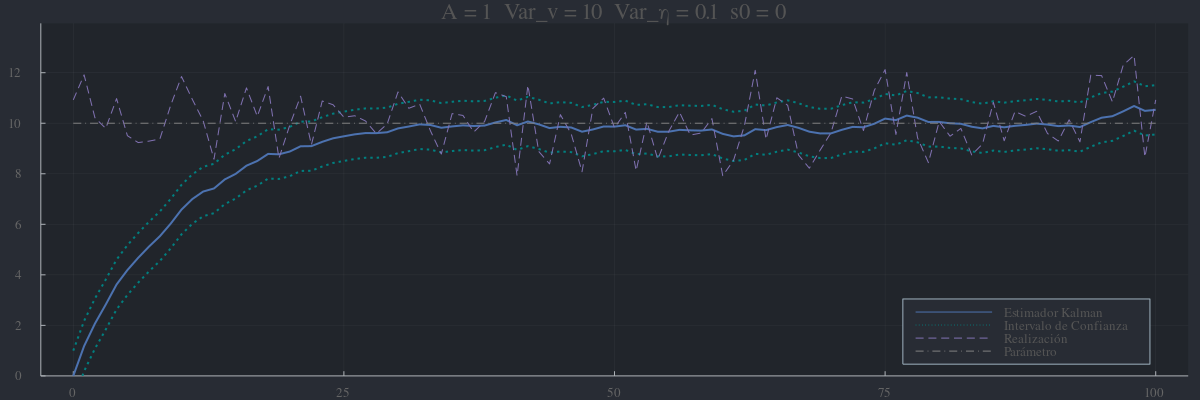

In [7]:
params = (A=1, Var_η=0.1, Var_v=10, s0=0, M0=1)

s, M, K = kalman(x; params...)
plot_kalman(x, s, 10, M; params...)

El filtro de Kalman ahora tiene una respuesta más lenta, pero su valor se mantiene más estable en torno al parámetro que estamos estimando

Evaluamos el efecto de confiar más en las mediciones que el modelo: `Var_η=10` y `Var_v=0.1`

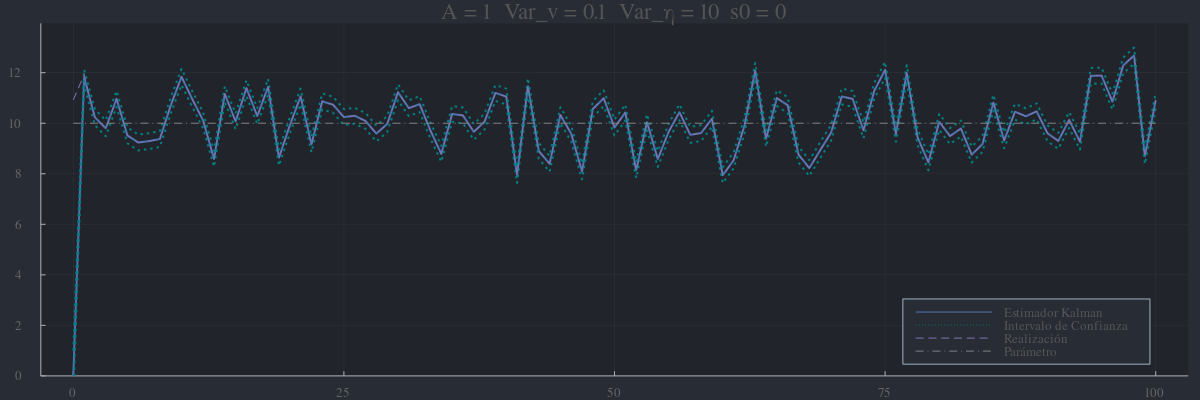

In [8]:
params = (A=1, Var_η=10, Var_v=0.1, s0=0, M0=1)

s, M, K = kalman(x; params...)
plot_kalman(x, s, 10, M; params...)

Ahora la respuesta del filtro es mucho más rápida, pero sigue en exceso a las mediciones, no siempre estimando el valor correcto del parámetro

Evaluamos reducir la incerteza del modelo a `Var_η=0`, es decir una estimación no-bayesiana

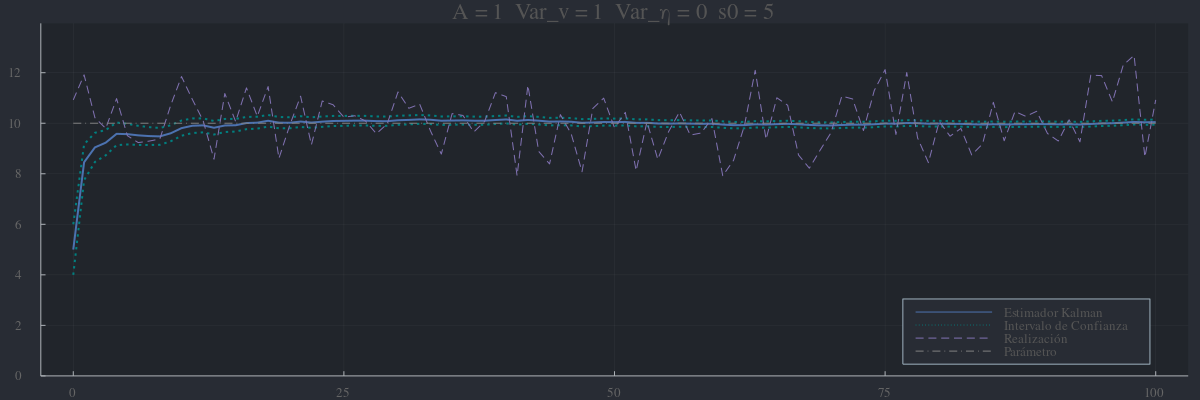

In [9]:
params = (A=1, Var_η=0, Var_v=1, s0=5, M0=1)

s, M, K = kalman(x; params...)
plot_kalman(x, s, 10, M; params...)

El filtro es muy estable respecto a las mediciones, pero aparenta resultar en una estimación sesgada.

Ahora evaluamos un modelo diferente, con parámetro de transición de estados `A=0.5`. Este modelo es incorrecto respecto a los datos generados en donde $s[n] = s[n-1]$, y esperamos ver eso reflejado en la estimación

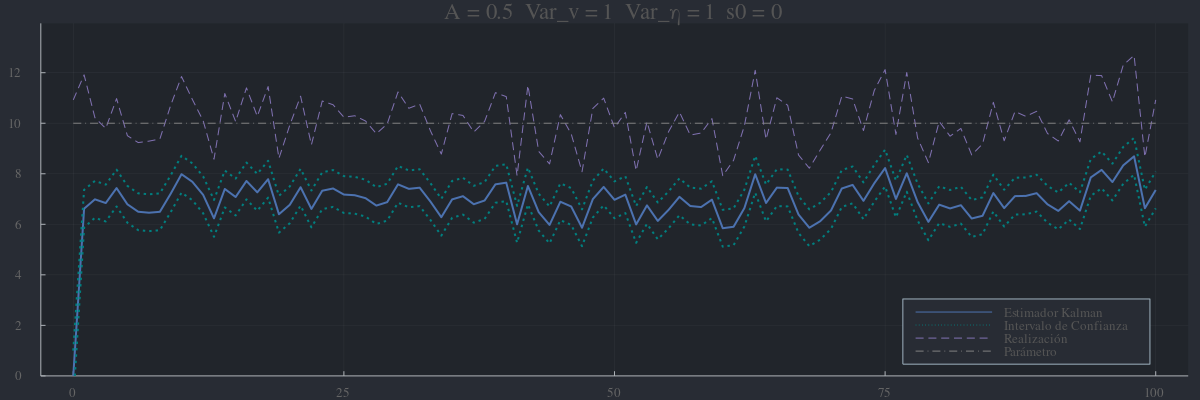

In [10]:
params = (A=0.5, Var_η=1, Var_v=1, s0=0, M0=1)

s, M, K = kalman(x; params...)
plot_kalman(x, s, 10, M; params...)

Efectivamente el resultado es incorrecto, sin embargo, podemos evaluar el efecto de usar un modelo incorrecto con `A=0.5` pero incrementar la incerteza del modelo a `Var_η=100`

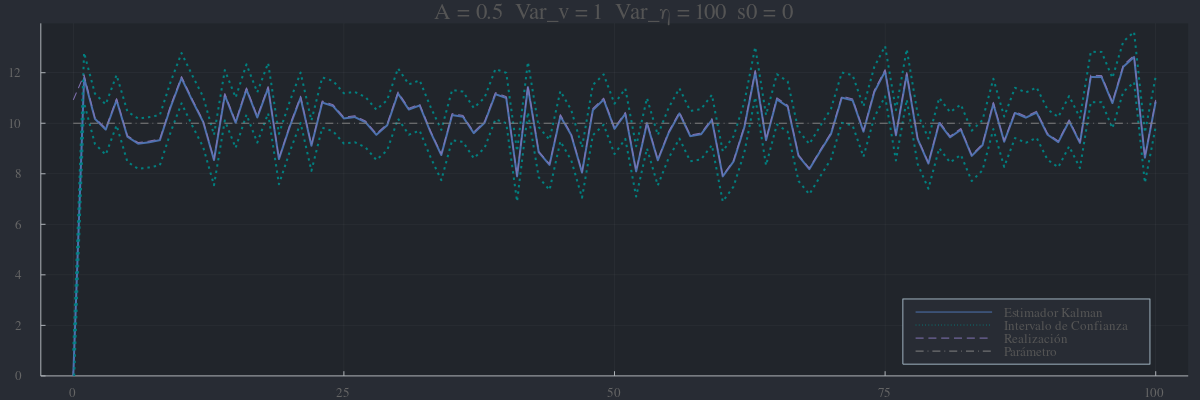

In [11]:
params = (A=0.5, Var_η=100, Var_v=1, s0=0, M0=1)

s, M, K = kalman(x; params...)
plot_kalman(x, s, 10, M; params...)

Efectivamente incrementar la incerteza del modelo hace que el filtro de Kalman haga una buena estimación del parámetro a pesar de usar un modelo incorrecto para representar los datos medidos

### Efecto de pérdida de datos en filtro de Kalman

Podemos ahora adaptar nuestra función de estimación de Kalman para que pueda reaccionar a mediciones perdidas, actualizando únicamente por modelo en ausencia de medición

In [12]:
function kalman(x; Var_v, Var_η, A, s0, M0)
    s_est = [A*s0]
    M_est = [A^2*M0+Var_η]
    K = [M_est[1]/(Var_v+M_est[1])]
    s = [s_est[1] + K[1]*(x[1]-s_est[1])]
    M = [(1-K[1])*M_est[1]]

    for i = 2:length(x)
        s_est = [s_est; A*s[i-1]]
        M_est = [M_est; A^2*M[i-1]+Var_η]
        if isnothing(x[i])
            s = [s; s_est[i]]
            M = [M; M_est[i]]
            K = [K; nothing]
        else 
            K = [K; M_est[i]/(Var_v+M_est[i])]
            s = [s; s_est[i] + K[i]*(x[i]-s_est[i])]
            M = [M; (1-K[i])*M_est[i]]
        end
    end
    return [s, M, K]
end

kalman (generic function with 1 method)

Simulamos la pérdida de las 20 mediciones $x[20],\, x[21],\, \dots,\, x[40]$, y aplicamos el filtro de Kalman

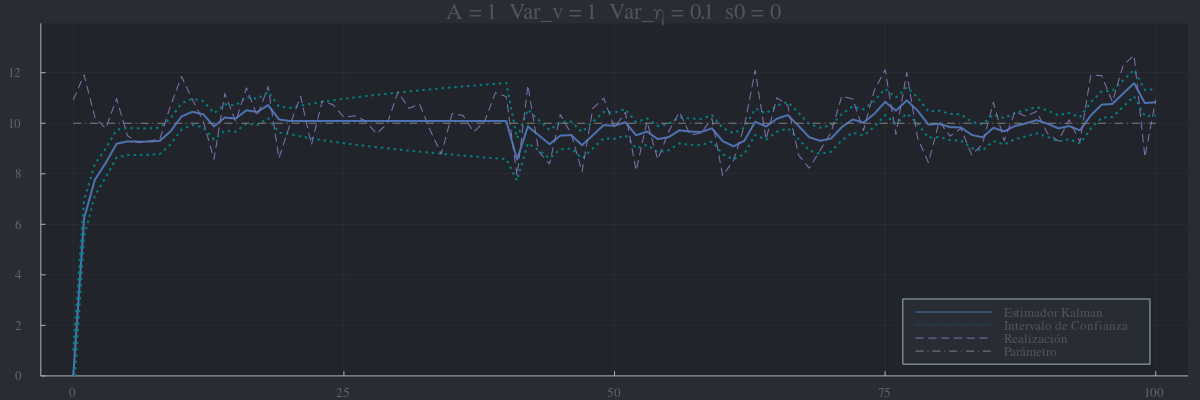

In [13]:
params = (A=1, Var_η=0.1, Var_v=1, s0=0, M0=1)

newx = [[x[i] for i in 1:20]...; [nothing for i in 21:40]...; [x[i] for i in 41:100]...]

s, M, K = kalman(newx; params...)
plot_kalman(x, s, 10, M; params...)

Vemos que la incerteza de la estimación incrementa conforme en cada instante en que la medición es perdida. La estimación es correcta por que estamos usando el modelo correcto para los datos, distinto sería si usáramos un modelo incorrecto:

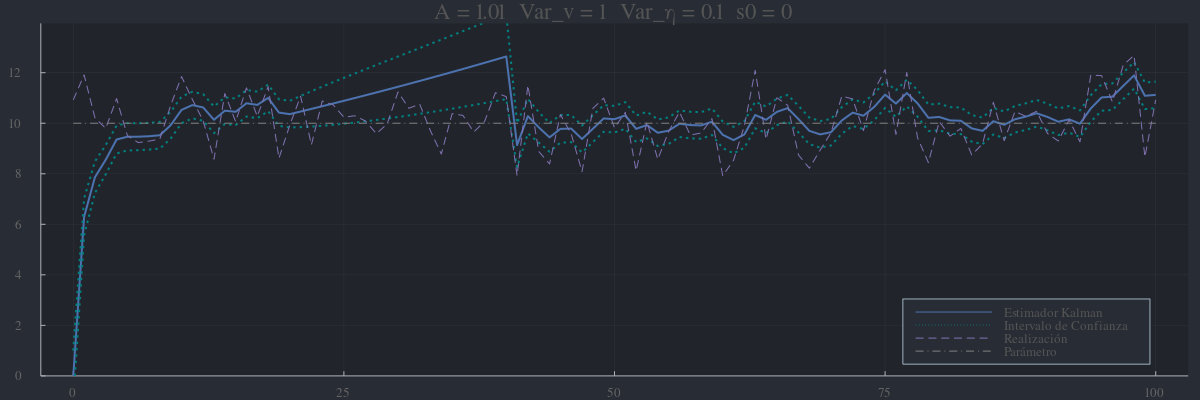

In [14]:
params = (A=1.01, Var_η=0.1, Var_v=1, s0=0, M0=1)

s, M, K = kalman(newx; params...)
plot_kalman(x, s, 10, M; params...)

### Aplicación del filtro de Kalman para el cálculo de la derivada

Consideramos el problema de encontrar la derivada de una señal senoidal ruidosa 
$$\tilde s[n] = s[n] + w[n] \qquad \text{con}\qquad \begin{aligned}s[n]&=\sin(6\pi\Delta_T n)\\w[n]&\sim\mathcal N(0, \sigma_w^2)\end{aligned}$$

Observamos el efecto de realizar una derivada numérica por el método habitual de diferencias finitas
$$\tilde s'[n] = \frac{\tilde s[n]-\tilde s[n-1]}{\Delta_T}$$

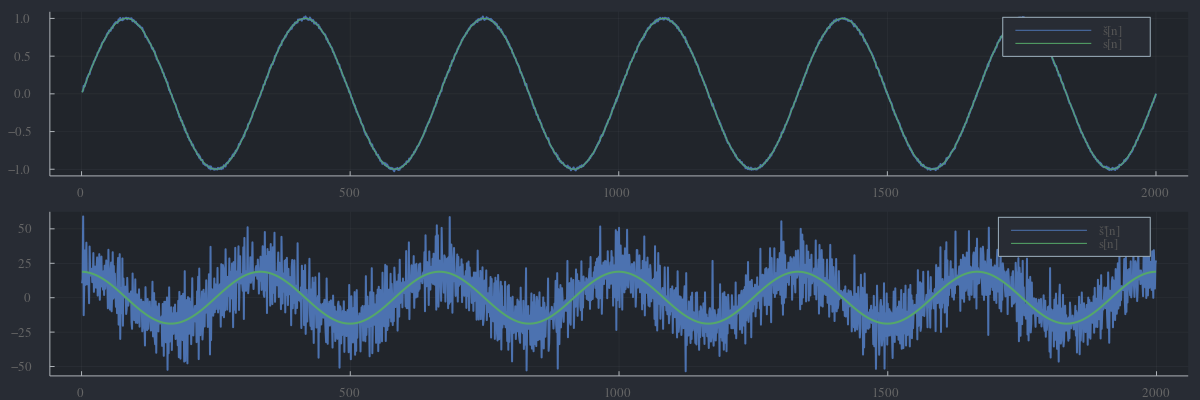

In [15]:
N = 2000
n = 1:N
ΔT = 0.001
s = sin.(6π*n*ΔT)
dsdt = diff(s)./ΔT
s_ruido = s .+ rand(Normal(0, 0.01), N)
dsdt_ruido = diff(s_ruido)./ΔT;

p1 = plot(s_ruido, label="š[n]"); plot!(p1, s, label="s[n]", linewidth=1)
p2 = plot(dsdt_ruido, label="š'[n]"); plot!(p2, dsdt, label="s[n]")
plot(p1,p2,layout=(2,1))

Observamos que incluso si el ruido es chico, afecta significativamente a la derivada. Esto es porque la derivada numérica actúa como filtro pasa alto, amplificando el ruido de alta frecuencia respecto a la frecuencia de la portadora.

Proponemos entonces usar un filtro de Kalman vectorial

$$\begin{aligned}
    \mathbf y[n] &= \mathbf A \mathbf y[n-1] + \mathbf b \eta[n]\\[1em]
    x[n] &= \mathbf h ^ T \mathbf y[n] + \nu[n]
\end{aligned}
    \qquad\text{con}\qquad
\mathbf y [n] = \begin{bmatrix}s[n]\\[0.5em] s'[n]\end{bmatrix} \qquad
x[n] = \tilde s[n] \qquad
\mathbf A = \begin{bmatrix}1&\Delta_T\\ 0&1\end{bmatrix} \qquad
\mathbf b = \begin{bmatrix}0\\1\end{bmatrix} \qquad
\mathbf h = \begin{bmatrix}1\\0\end{bmatrix} \qquad
$$

Explícitamente, el modelo propuesto se reduce a un sistema de tres ecuaciones lineales:

- Un incremento en la señal expresado como diferencia finita 
 $$s[n] = s[n-1]+\Delta_T s'[n-1]$$

- La incerteza del modelo respecto a la derivada de la señal
$$s'[n] = s'[n-1] + \eta[n] $$

- El ruido de medición sobre la señal
$$\tilde s[n] = s[n] + \nu[n]$$

In [16]:
A=[1 ΔT; 0 1]
b=[0; 1]
h=[1; 0];

In [17]:
function kalman_vec(x; Var_v, Var_η, A, b, h, y0, M0)
    K = Vector{Float64}[]
    y = Vector{Float64}[]
    M = Matrix{Float64}[]

    y_est = A*y0
    M_est = A*M0*A'+b*Var_η*b'
    push!(K, M_est*h/(Var_v+h'*M_est*h))
    push!(y, y_est + K[1]*(x[1]-h'y_est))
    push!(M, ([1 0;0 1]-K[1]*h')*M_est)

    for i = 2:length(x)
        y_est = A*y[i-1]
        M_est = A*M[i-1]*A'+b*Var_η*b'
        push!(K, M_est*h/(Var_v+h'*M_est*h))
        push!(y, y_est + K[i]*(x[i]-h'*y_est))
        push!(M, ([1 0;0 1]-K[i]*h')*M_est)
    end
    return [y, M, K]
end

kalman_vec (generic function with 1 method)

En cada caso graficamos 

- El valor de la derivada numérica sin ruido $s'[n]$
- El resultado de el filtro de Kalman para la derivada $\tilde s'[n]$
- El intervalo de confianza

In [18]:
function plot_kalman_vec(dsdt, y, M; Var_v, Var_η, A, b, h, y0, M0)
    lim = maximum(abs.([extrema(x)..., extrema(s)...]))*1.1
    dsdt_k = map(last, y) 
    var_k = map(x -> x[2,2], M)
    smin = [y0[2]-sqrt(M0[2,2]); dsdt_k.-sqrt.(var_k)]
    smax = [y0[2]+sqrt(M0[2,2]); dsdt_k.+sqrt.(var_k)]
    vars = [smin, smax]

    p2 = plot(title="Var_v = $Var_v,  Var_η = $Var_η")
    plot!(p2, dsdt); 
    plot!(p2, dsdt_k)
    plot!(p2, vars, linestyle=:dot, color=:teal)
end

plot_kalman_vec (generic function with 1 method)

Evaluamos como referencia un filtro de Kalman con igual confianza en las mediciones que en el modelo, `Var_η=0.1`, `Var_v=0.1`

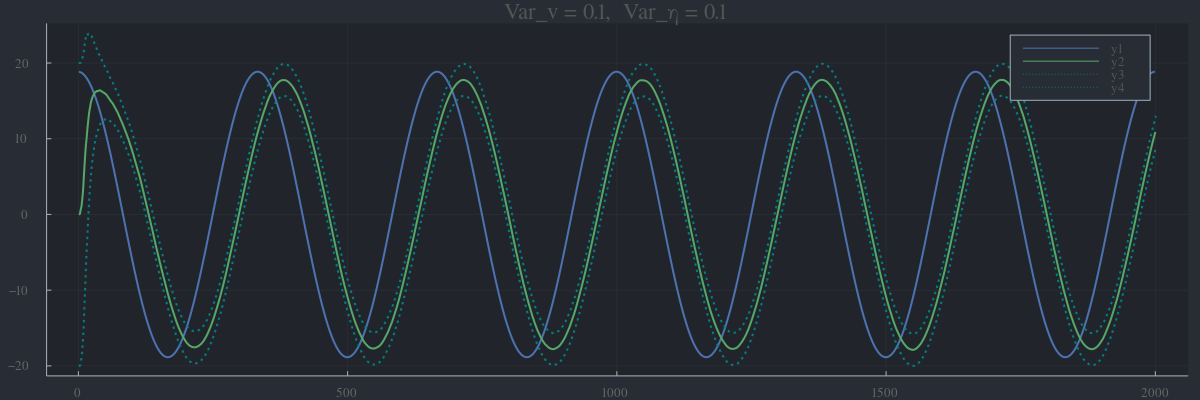

In [19]:
params = (Var_v=0.1, Var_η=0.1, A=A, b=b, h=h, y0=[0; 0], M0=[20^2 0; 0 20^2])
y, M, K = kalman_vec(s_ruido; params...);

plot_kalman_vec(dsdt, y, M; params...)

Comparamos con el efecto de confiar más en el modelo que en las mediciones `Var_η=0.01`, `Var_v=1`

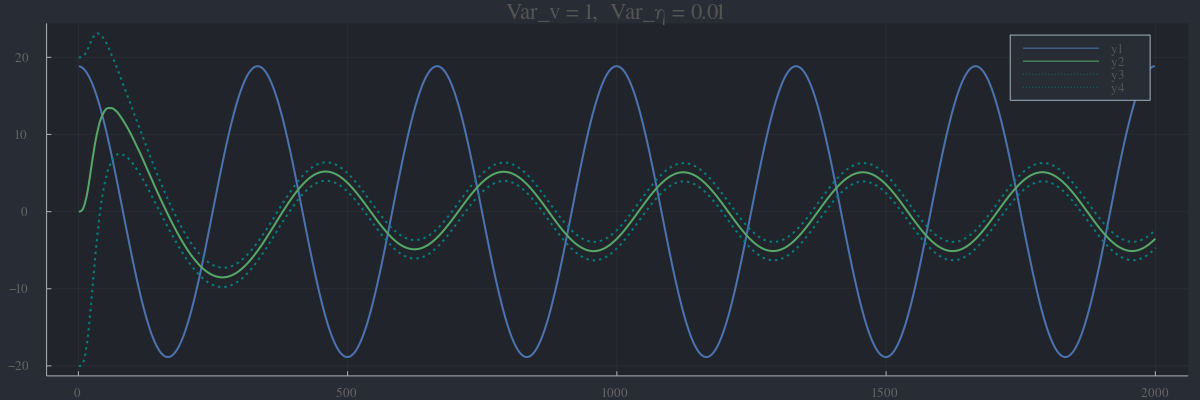

In [20]:
params = (Var_v=1, Var_η=0.01, A=A, b=b, h=h, y0=[0; 0], M0=[20^2 0; 0 20^2])
y, M, K = kalman_vec(s_ruido; params...);

plot_kalman_vec(dsdt, y, M; params...)

En este caso el resultado no refleja en su totalidad la derivada de la señal, ya que la varianza del modelo no alcanza a capturar el rango de variación de $s'[n]$

Y comparamos con el efecto de confiar más en las mediciones que en el modelo, `Var_η=1`, `Var_v=0.01`

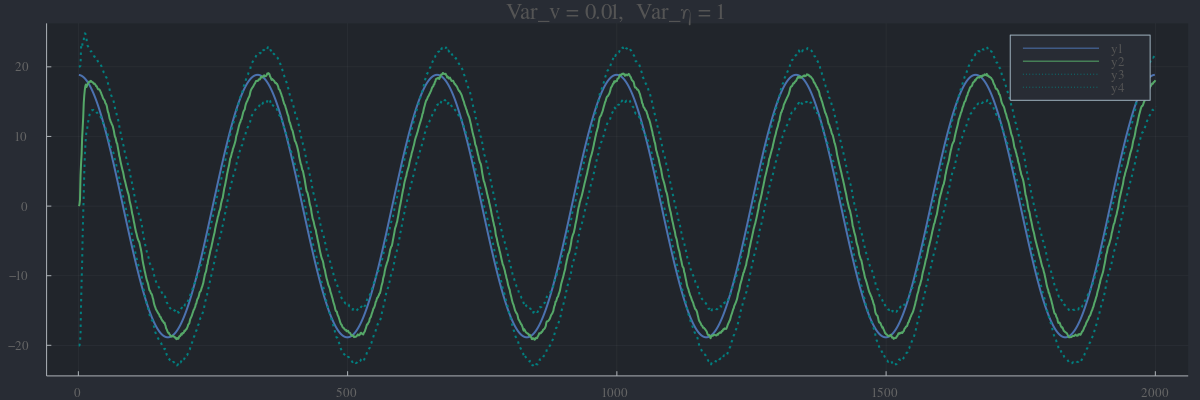

In [22]:
params = (Var_v=0.01, Var_η=1, A=A, b=b, h=h, y0=[0; 0], M0=[20^2 0; 0 20^2])
y, M, K = kalman_vec(s_ruido; params...);

plot_kalman_vec(dsdt, y, M; params...)

En este caso se consigue un filtro con respuesta más rápida, pero una señal de salida más ruidosa por confiar más en las mediciones. Sin embargo, el ruido es mucho menor que el obtenido con simplemente hacer la derivada numérica.